In [1]:

# used libraries 
import json
import pandas as pd
import matplotlib.pyplot as plt

# Similar Player Component used libraries 
from sklearn.metrics.pairwise import cosine_similarity # Cosine Similarity
from sklearn.cluster import KMeans # Kmeans clustering

# evaluation
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Scouter AI Component used libraries
import os 
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# evaluation
from rouge_score import rouge_scorer
from bert_score import score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

### Simple cosine similarity between players

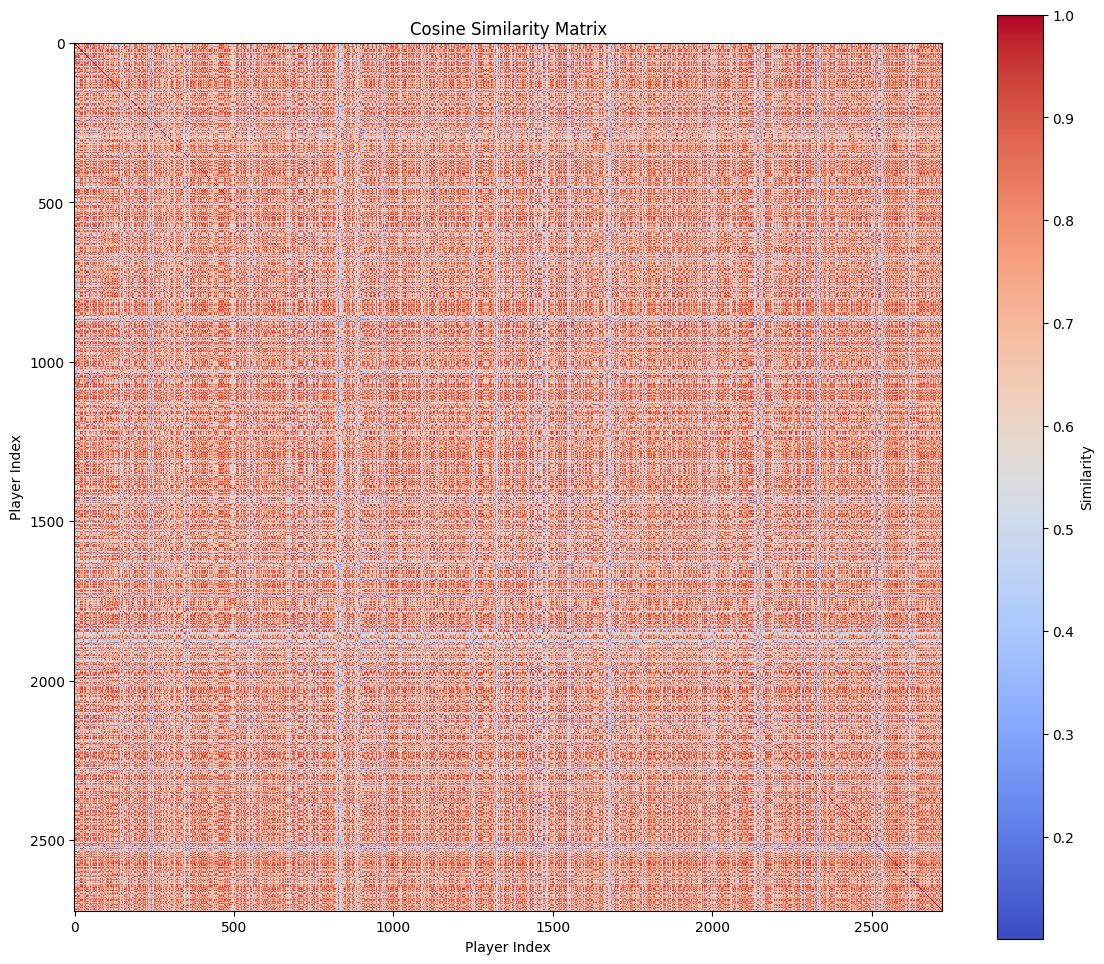

In [2]:
df = pd.read_csv("data_player/football-player-stats-2023.csv")

df_player_norm = df.copy()
custom_mapping = {
    'GK': 1,
    'DF,FW': 4,
    'MF,FW': 8,
    'DF': 2,
    'DF,MF': 3,
    'MF,DF': 5,
    'MF': 6,
    'FW,DF': 7,
    'FW,MF': 9,
    'FW': 10
}

# Apply custom mapping to the 'Pos' column
df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

selected_features = ['Pos', 'Age','Playing Time MP', 'Performance Gls', 'Performance Ast',
       'Performance G+A', 'Performance G-PK', 'Performance Fls',
       'Performance Fld', 'Performance Crs', 'Performance Recov',
       'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
       'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
       'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
       'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
       'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
       'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
       'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
       'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
       'Performance Saves', 'Performance Save%', 'Performance CS',
       'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
       'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
       'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
       'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

# Apply MinMaxScaler normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])
similarity = cosine_similarity(df_player_norm[selected_features])

# Plot Cosine Similarity Matrix
plt.figure(figsize=(14, 12))
plt.imshow(similarity, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Player Index')
plt.ylabel('Player Index')
plt.show()

### Function to find the similar playerers using only cosine simialarity

In [3]:
def find_similar_player(i,similarity):
    similarity_score = list(enumerate(similarity[i]))
    similar_players = sorted(similarity_score, key=lambda x:x[1], reverse=True)
    # Creating a list to store the data of similar players
    similar_players_data = []

    # Cycle to extract information from similar players
    for player in similar_players[1:11]:
        index = player[0]
        player_records = df[df['Rk'] == index]
        if not player_records.empty:
            player_data = player_records.iloc[0] 
            similar_players_data.append(player_data)

    # Creating a DataFrame from the data of similar players
    similar_players_df = pd.DataFrame(similar_players_data)

    return similar_players_df

In [4]:
a = find_similar_player(0,similarity)
a

Rk                 Player Nation    Pos           Squad  \
2017  2017          Gonzalo Plata    ECU     FW      Valladolid   
727    727             Ritsu Doan    JPN  MF,FW        Freiburg   
1160  1160           Adrien Hunou    FRA  MF,FW          Angers   
1475  1475         Sean Longstaff    ENG     MF   Newcastle Utd   
1644  1644            John McGinn    SCO  MF,FW     Aston Villa   
1274  1274         Jakub Kamiński    POL  FW,DF       Wolfsburg   
1915  1915  Isaac Palazón Camacho    ESP  FW,MF  Rayo Vallecano   
2077  2077           Jacob Ramsey    ENG  MF,FW     Aston Villa   
492    492           Fares Chaïbi    ALG  FW,MF        Toulouse   
2643  2643            Joe Willock    ENG     MF   Newcastle Utd   

                Comp  Age  Born  Playing Time MP  Performance Gls  ...  \
2017         La Liga   23  2000               34                1  ...   
727       Bundesliga   25  1998               33                5  ...   
1160         Ligue 1   29  1994               34                4  ...   
1475  Premier League   26  1997               33                1  ...   
1644  Premier League   29  1994               34                1  ...   
1274      Bundesliga   21  2002               31                4  ...   
1915         La Liga   29  1994               37                9  ...   
2077  Premier League   22  2001               35                6  ...   
492          Ligue 1   21  2002               36                5  ...   
2643  Premier League   24  1999               35                3  ...   

      Total Cmp  Total Att  Total Cmp%  Total TotDist  Total PrgDist  KP  1/3  \
2017        582        782        74.4           7367           1681  37   28   
727         437        625        69.9           6572           1840  27   44   
1160        572        753        76.0           8441           2005  18   38   
1475        943       1163        81.1          15457           4299  23   80   
1644        805       1028        78.3          14385           4830  18  114   
1274        495        667        74.2           7398           2278  28   30   
1915        979       1376        71.1          16672           4781  66   84   
2077        728        889        81.9          10240           2665  42   67   
492         742       1018        72.9          11489           3144  30   68   
2643        777        951        81.7          12123           3082  39   91   

      PPA  CrsPA  PrgP  
2017   19      3    54  
727    28      5    69  
1160   12      1    62  
1475   21      5   116  
1644   20      5   140  
1274   39      5    78  
1915   47     11   127  
2077   28      4    98  
492    27      5   101  
2643   34      8   121  

[10 rows x 69 columns]

### Finding the number of clusters

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

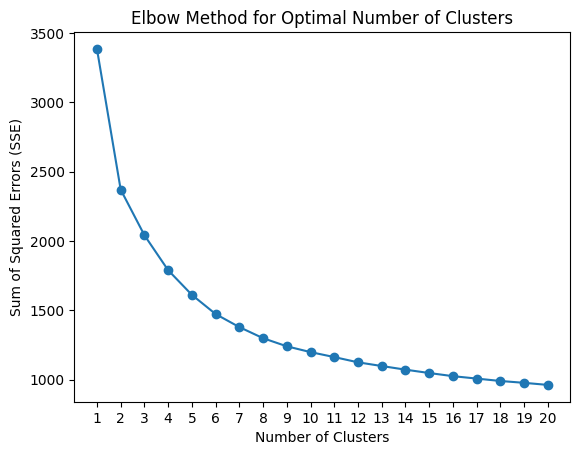

In [5]:
# Calculation of SSE (inertia) for different cluster values
sse_values = []
possible_clusters = range(1, 21)  # test with range of 20 clusters

for num_clusters in possible_clusters:
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_player_norm[selected_features])
    sse_values.append(kmeans_model.inertia_)

# Visualisation of SSE trend
plt.plot(possible_clusters, sse_values, marker='o')
plt.xticks(possible_clusters, possible_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

### 4 is the total number of clusters, therefore, we have the final clustered dataset

In [6]:
# Specifies the desired number of clusters
num_clusters = 4

# Create an instance of the K-Means model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Train the model on player features
kmeans_model.fit(df_player_norm[selected_features])

# Get the cluster labels assigned to players
cluster_labels = kmeans_model.labels_

# Add cluster labels to the player dataframe
df_player_norm['Cluster'] = cluster_labels
df['Cluster'] = cluster_labels

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=4): {silhouette_score(df_player_norm[selected_features], cluster_labels)}')

Silhouette Score(n=4): 0.274574188555236


### function to find 10 similar players using cosine similarity and the custered data
1. This function will initially find the clusters 
2. Then it will creat a cosine similarity matrix between the players of the respective clusters
3. Finally it will then give us the top ten most similar players

In [8]:
def find_similar_players(i,df):  
    # # Filter the dataframe for players in the same cluster as the target player
    df_player_norm = df.copy()
    custom_mapping = {
        'GK': 1,
        'DF,FW': 4,
        'MF,FW': 8,
        'DF': 2,
        'DF,MF': 3,
        'MF,DF': 5,
        'MF': 6,
        'FW,DF': 7,
        'FW,MF': 9,
        'FW': 10
    }

# Apply custom mapping to the 'Pos' column
    df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

    selected_features = ['Pos', 'Age','Playing Time MP', 'Performance Gls', 'Performance Ast',
           'Performance G+A', 'Performance G-PK', 'Performance Fls',
           'Performance Fld', 'Performance Crs', 'Performance Recov',
           'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
           'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
           'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
           'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
           'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
           'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
           'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
           'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
           'Performance Saves', 'Performance Save%', 'Performance CS',
           'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
           'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
           'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
           'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

    scaler = MinMaxScaler()
    df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])
    df_player_norm['Cluster']=df['Cluster']
    # Select the player of interest (target)
    target_player = df_player_norm[df_player_norm['Rk'] == i]
    target_features = target_player[selected_features]
    target_cluster = target_player['Cluster'].iloc[0]  # Get the cluster label of the target player
    
    similar_players_cluster_df = df_player_norm[df_player_norm['Cluster'] == target_cluster].copy()
    # # Calculate cosine similarity between the target player and other players in the same cluster
    similarities = cosine_similarity(target_features, similar_players_cluster_df[selected_features])
    similarities = similarities[0] * 100
    # # Add the 'Similarity' column to the dataframe using .loc
    similar_players_cluster_df.loc[:, 'Similarity'] = similarities

    # # Sort the DataFrame based on the 'Similarity' column in descending order
    similar_players_cluster_df = similar_players_cluster_df.sort_values(by='Similarity', ascending=False)

    # # Select from the second to the 11th element (remembering that indexing starts from 0)
    similar_players_cluster_df = similar_players_cluster_df.iloc[0:11]


    # # Retrieve the non-normalized data from the original dataframe
    similar_players_cluster_df = df[df['Rk'].isin(similar_players_cluster_df['Rk'])]

    return similar_players_cluster_df

In [9]:
a = find_similar_players(56,df)

In [10]:
a

Rk                     Player Nation    Pos           Squad  \
56      56               Lucas Alario    ARG  FW,MF  Eint Frankfurt   
670    670              Mattia Destro    ITA  FW,MF          Empoli   
710    710                 Lois Diony    FRA     FW          Angers   
794    794               Alberth Elis    HON  MF,FW           Brest   
833    833             Radamel Falcao    COL  FW,MF  Rayo Vallecano   
928    928  Silvère Ganvoula M'Boussy    CGO  FW,MF          Bochum   
1880  1880               Paul Onuachu    NGA     FW     Southampton   
2041  2041                Abdón Prats    ESP  FW,MF        Mallorca   
2140  2140            Ángel Rodríguez    ESP  FW,MF        Mallorca   
2163  2163             Salomón Rondón    VEN     FW         Everton   
2305  2305               Kaj Sierhuis    NED  FW,MF           Reims   

                Comp  Age  Born  Playing Time MP  Performance Gls  ...  \
56        Bundesliga   31  1992               20                1  ...   
670          Serie A   32  1991               17                1  ...   
710          Ligue 1   31  1992               11                1  ...   
794          Ligue 1   27  1996               10                0  ...   
833          La Liga   37  1986               27                2  ...   
928       Bundesliga   27  1996               16                0  ...   
1880  Premier League   29  1994               11                0  ...   
2041         La Liga   31  1992               26                1  ...   
2140         La Liga   36  1987               17                1  ...   
2163  Premier League   34  1989                7                0  ...   
2305         Ligue 1   25  1998               14                0  ...   

      Total Att  Total Cmp%  Total TotDist  Total PrgDist  KP  1/3  PPA  \
56           85        65.9            792            190   1    4    0   
670          79        55.7            518            127   4    1    2   
710         142        76.8           1202            221   5    6    2   
794          44        75.0            405            137   3    2    3   
833         167        73.7           1625            211   3    7    1   
928          87        56.3            669            184   5    8    5   
1880         91        60.4            757            157   4    4    2   
2041         91        63.7            874            173   7    4    3   
2140         82        72.0            839            183   3    6    1   
2163         29        75.9            203             35   2    2    1   
2305         64        51.6            627            107   0    2    0   

      CrsPA  PrgP  Cluster  
56        0     8        2  
670       0     4        2  
710       1    11        2  
794       1     4        2  
833       0    14        2  
928       0    12        2  
1880      0     7        2  
2041      0     8        2  
2140      0     6        2  
2163      0     1        2  
2305      0     3        2  

[11 rows x 70 columns]

In [11]:
# df.to_csv("Final_player_cluster_df.csv")

In [12]:
def find_similar_players(i,df):  
    # # Filter the dataframe for players in the same cluster as the target player
    df_player_norm = df.copy()
    custom_mapping = {
        'GK': 1,
        'DF,FW': 4,
        'MF,FW': 8,
        'DF': 2,
        'DF,MF': 3,
        'MF,DF': 5,
        'MF': 6,
        'FW,DF': 7,
        'FW,MF': 9,
        'FW': 10
    }

# Apply custom mapping to the 'Pos' column
    df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

    selected_features = ['Pos', 'Age','Playing Time MP', 'Performance Gls', 'Performance Ast',
           'Performance G+A', 'Performance G-PK', 'Performance Fls',
           'Performance Fld', 'Performance Crs', 'Performance Recov',
           'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
           'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
           'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
           'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
           'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
           'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
           'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
           'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
           'Performance Saves', 'Performance Save%', 'Performance CS',
           'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
           'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
           'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
           'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

    scaler = MinMaxScaler()
    df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])
    df_player_norm['Cluster']=df['Cluster']
    # Select the player of interest (target)
    target_player = df_player_norm[df_player_norm['Rk'] == i]
    target_features = target_player[selected_features]
    target_cluster = target_player['Cluster'].iloc[0]  # Get the cluster label of the target player
    
    similar_players_cluster_df = df_player_norm[df_player_norm['Cluster'] == target_cluster].copy()
    # # Calculate cosine similarity between the target player and other players in the same cluster
    similarities = cosine_similarity(target_features, similar_players_cluster_df[selected_features])
    similarities = similarities[0] * 100
    # # Add the 'Similarity' column to the dataframe using .loc
    similar_players_cluster_df.loc[:, 'Similarity'] = similarities

    # # Sort the DataFrame based on the 'Similarity' column in descending order
    similar_players_cluster_df = similar_players_cluster_df.sort_values(by='Similarity', ascending=False)

    # # Select from the second to the 11th element (remembering that indexing starts from 0)
    similar_players_cluster_df = similar_players_cluster_df.iloc[1:11]


    # # Retrieve the non-normalized data from the original dataframe
    similar_players_cluster_df = df[df['Rk'].isin(similar_players_cluster_df['Rk'])]

    params = ['Expected xG', 'Performance G+A', 'Expected xG', 
              'Standard Dist', 'Performance CS', 'Total Att', 
              'Aerial Duels Won', 'Standard SoT%', 'Total PrgDist']
    low = []
    high = []

    for i in params:
        low.append(similar_players_cluster_df[i].min())
        high.append(similar_players_cluster_df[i].max())

    # Assuming Radar is a class that has been defined elsewhere in your code
    radar = Radar(params, low, high,
                  round_int=[False]*len(params),
                  num_rings=4,
                  ring_width=0.5, center_circle_radius=0.5)

    for i in range(len(similar_players_cluster_df)):
        player_name = similar_players_cluster_df.iloc[i]['Player']
        player_val = similar_players_cluster_df.iloc[i][params].values
        fig, ax = radar.setup_axis()  # format axis as a radar
        rings_inner = radar.draw_circles(ax=ax, facecolor='#ffb2b2', edgecolor='#fc5f5f')  # draw circles
        radar_output = radar.draw_radar(player_val, ax=ax,
                                        kwargs_radar={'facecolor': '#aa65b2'},
                                        kwargs_rings={'facecolor': '#66d8ba'})  # draw the radar
        radar_poly, rings_outer, vertices = radar_output
        range_labels = radar.draw_range_labels(ax=ax, fontsize=15)  # draw the range labels
        param_labels = radar.draw_param_labels(ax=ax, fontsize=15)  # draw the param labels
        title = ax.set_title(f'Radar Chart for {player_name}', fontsize=20)
        title.set_position([0.5, 1.05])  # Adjust the position (x, y) relative to the axes (0-1)

        # Save the chart to a file
    #     plt.savefig(f'RadarChart_{player_name}.png')
        plt.show()  # Show the figure
        plt.close()  # Close the current figure to release memory

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


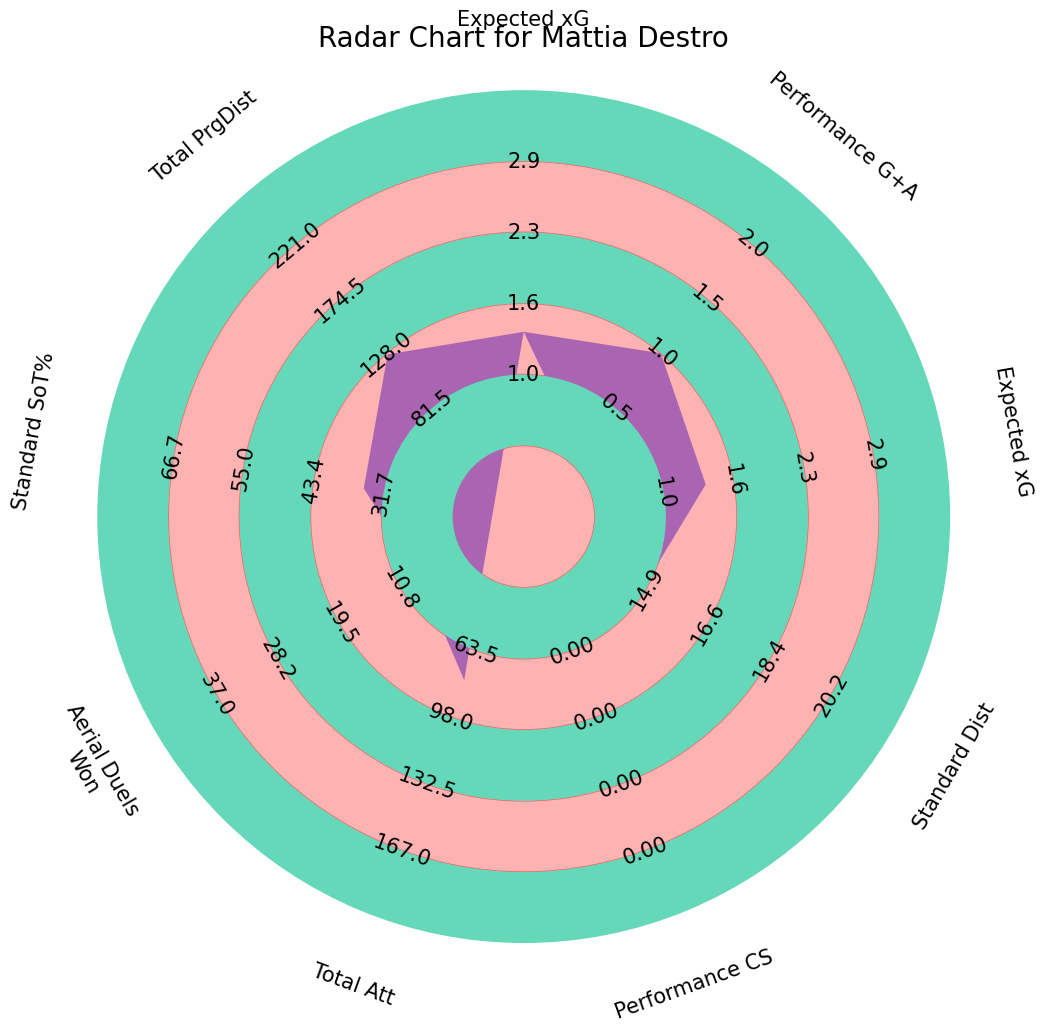

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


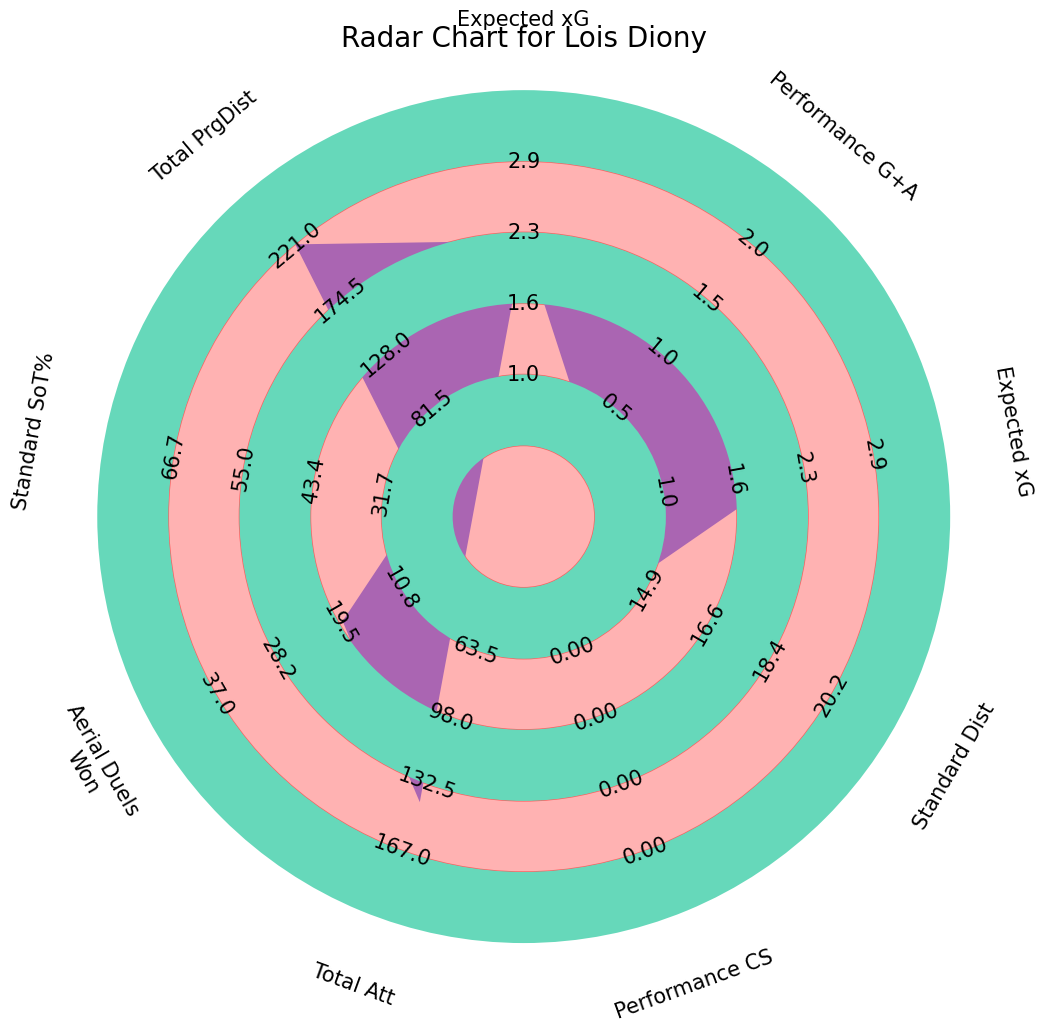

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


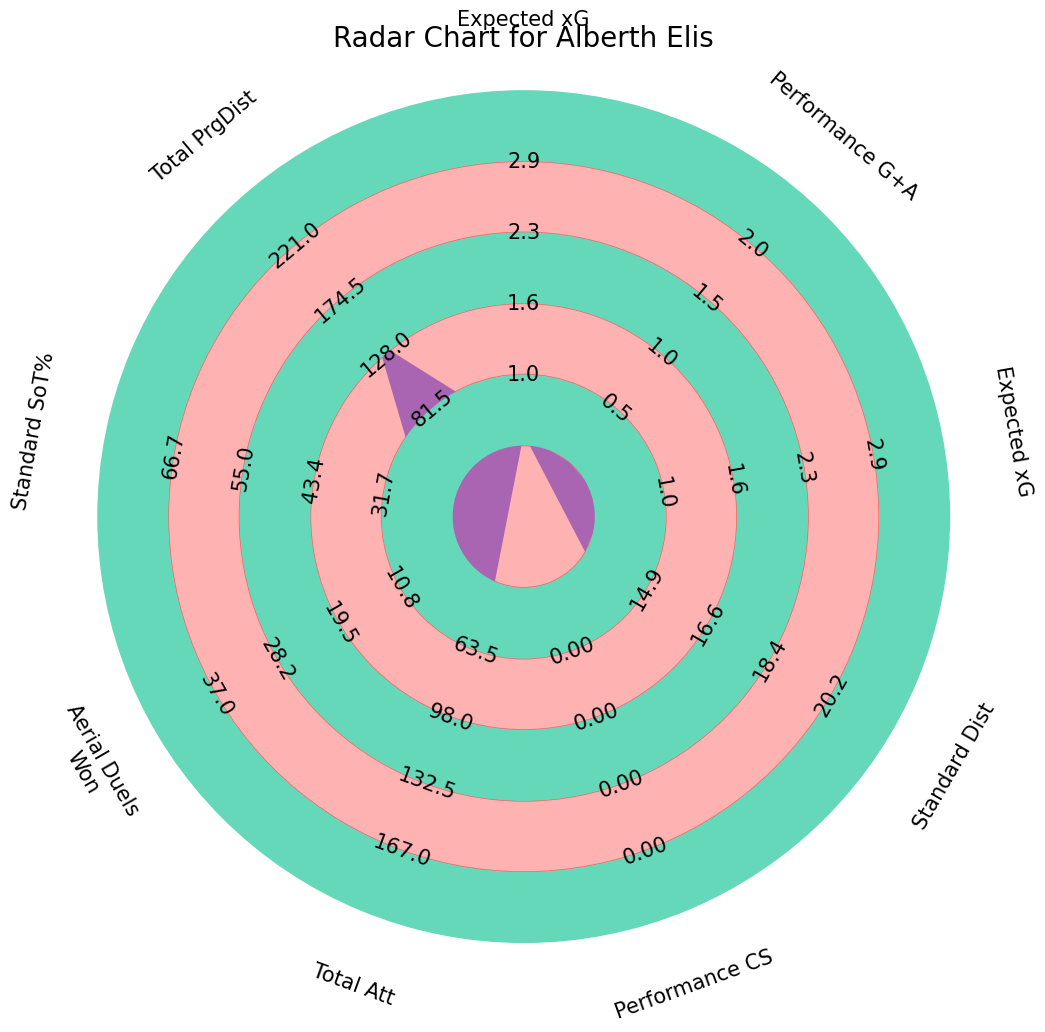

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


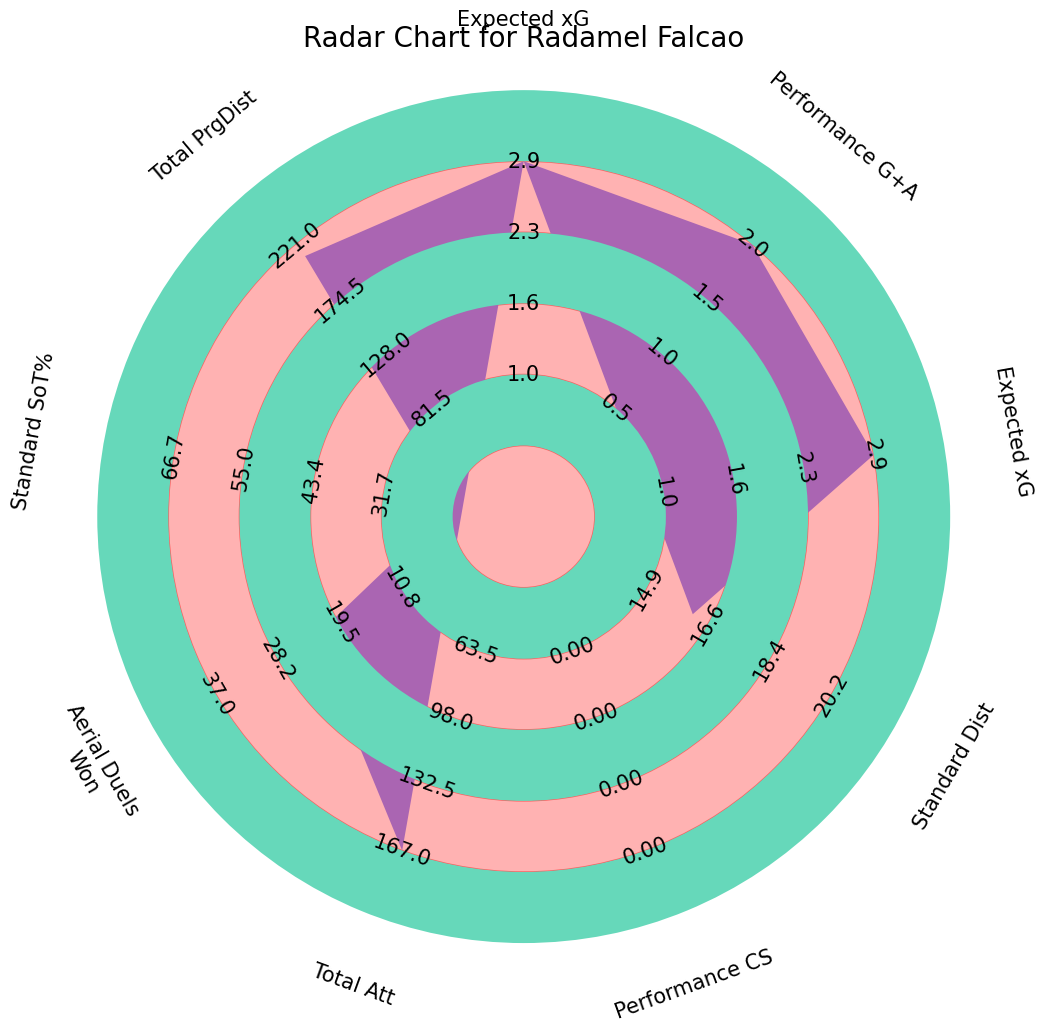

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


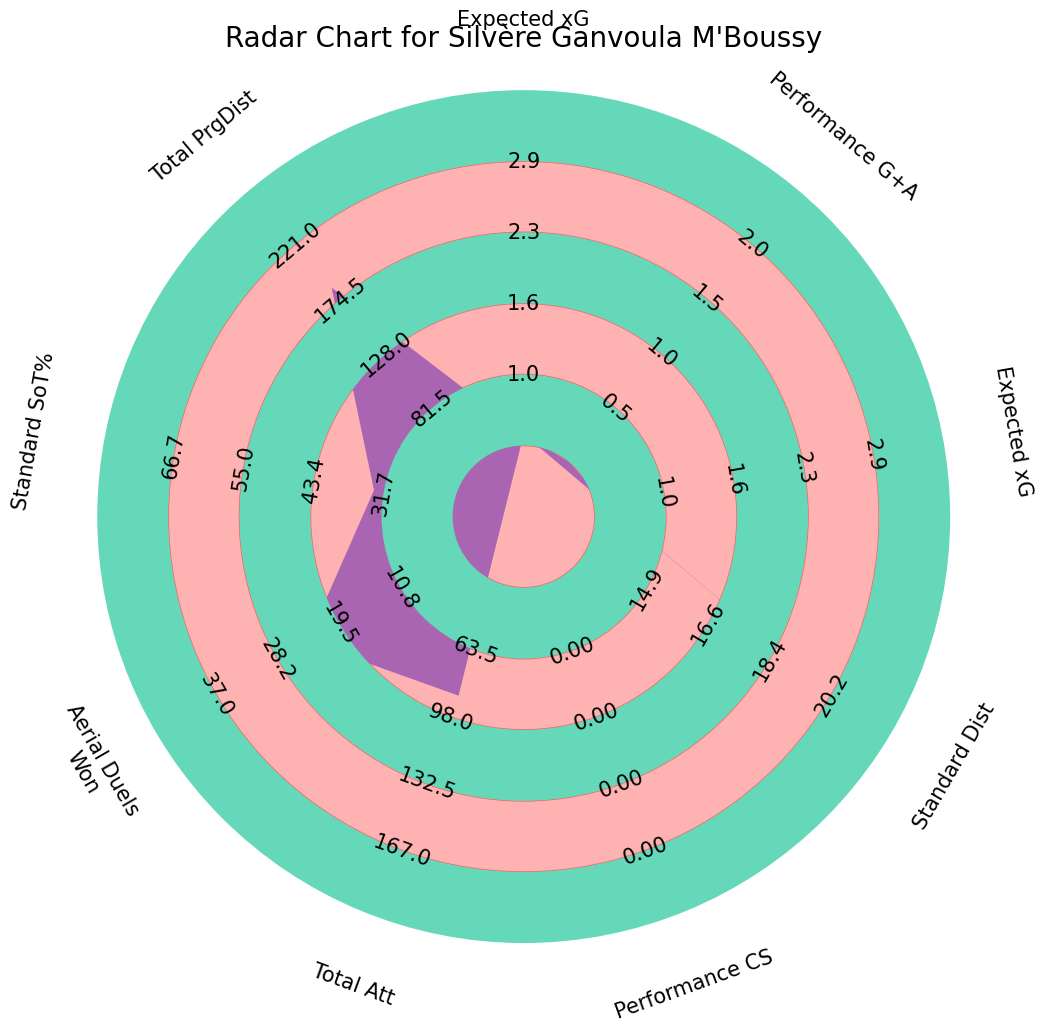

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


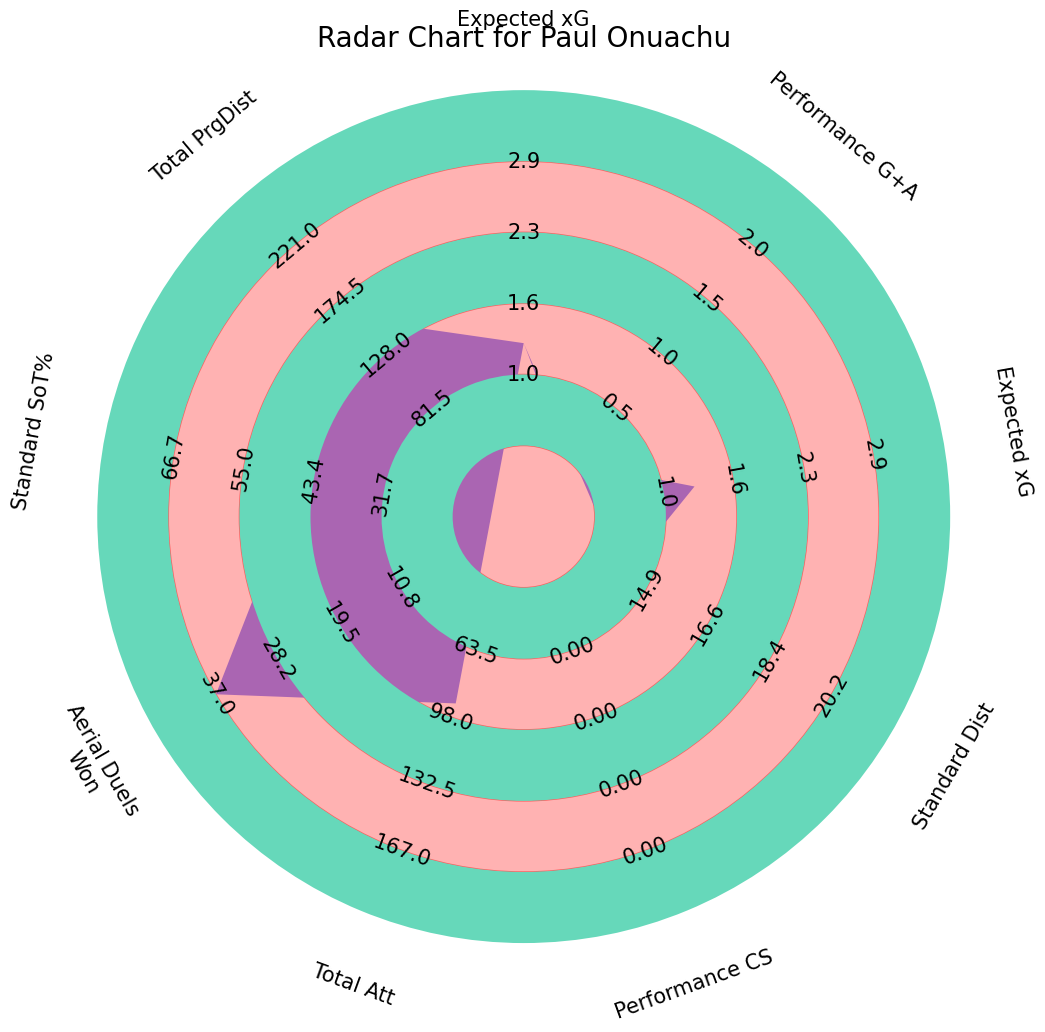

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


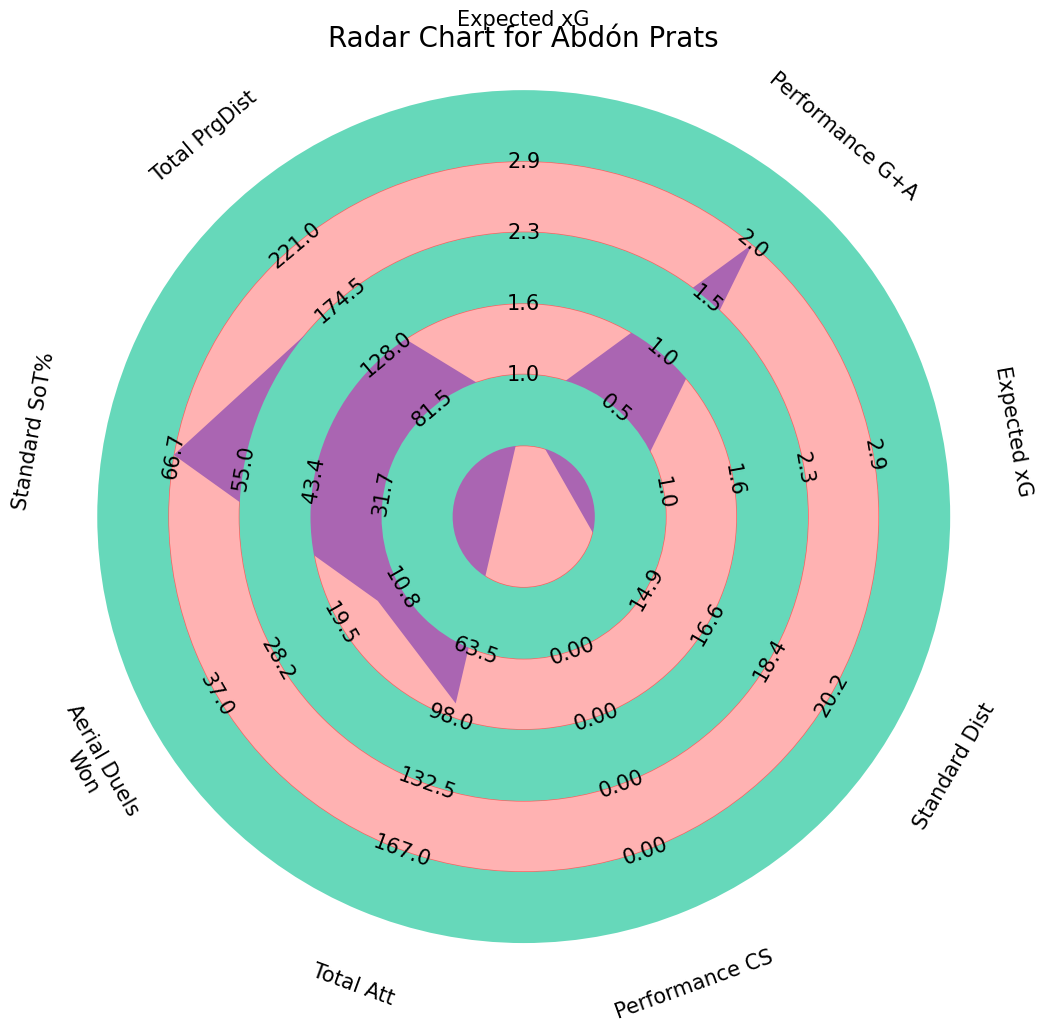

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


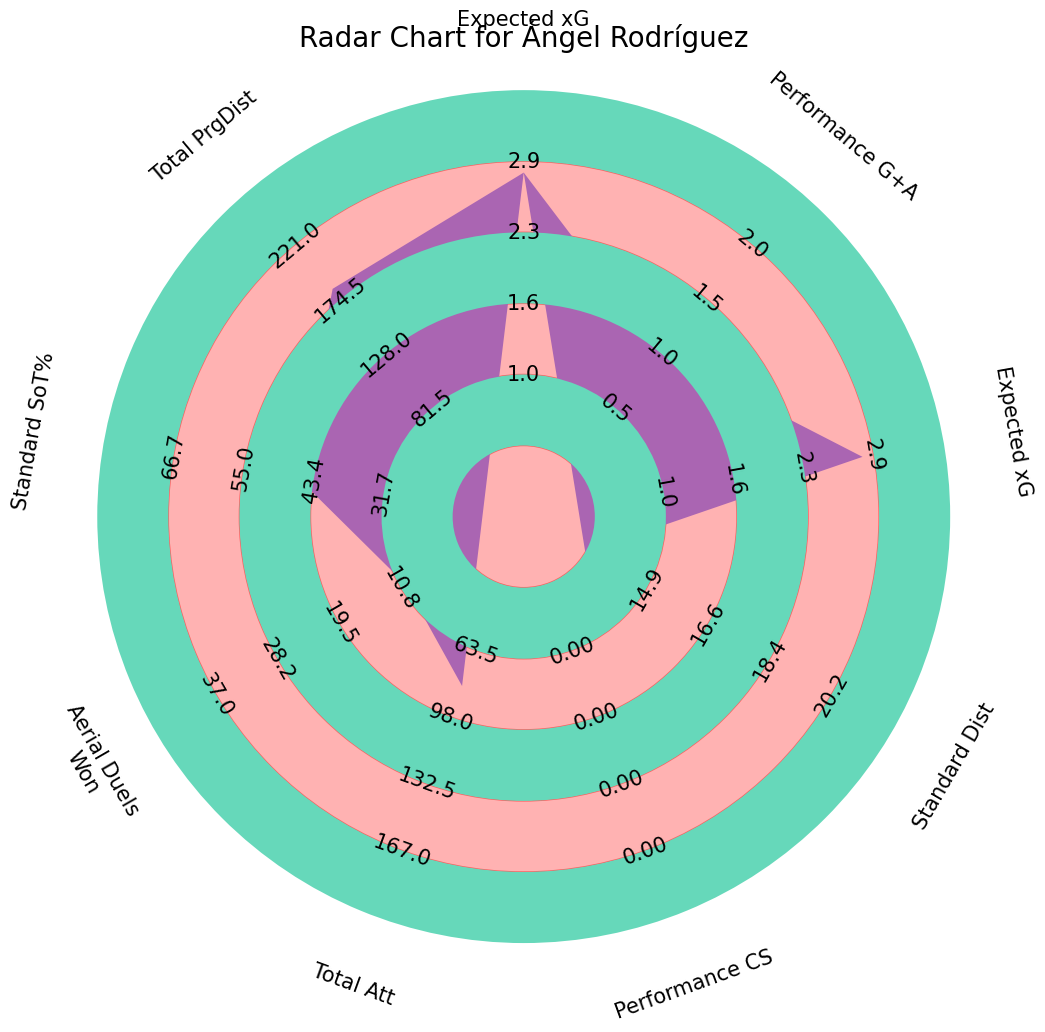

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


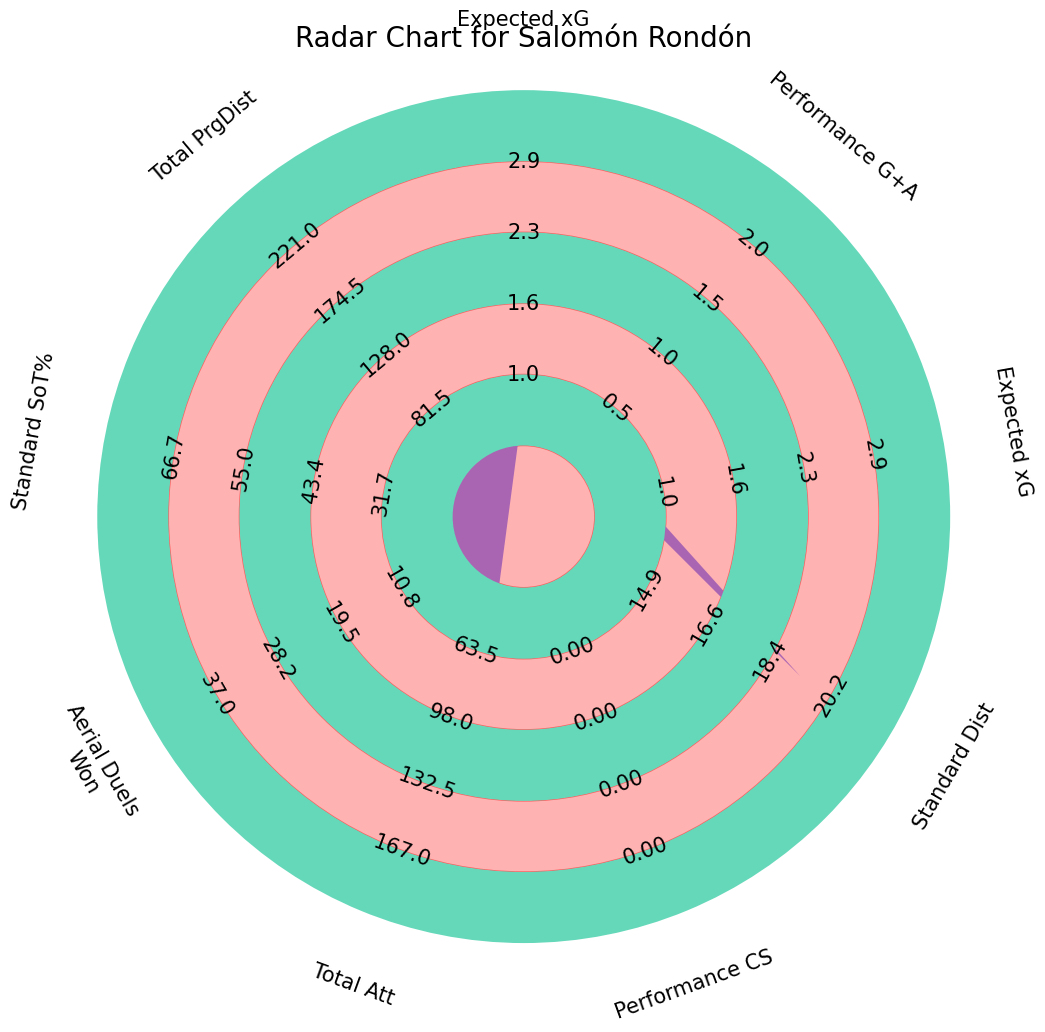

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/mplsoccer/radar_chart.py:238: RuntimeWarning: invalid value encountered in scalar divide
  proportion = np.abs(values_clipped - self.min_range) / label_range
Ill-defined clip_path detected. Returning None.


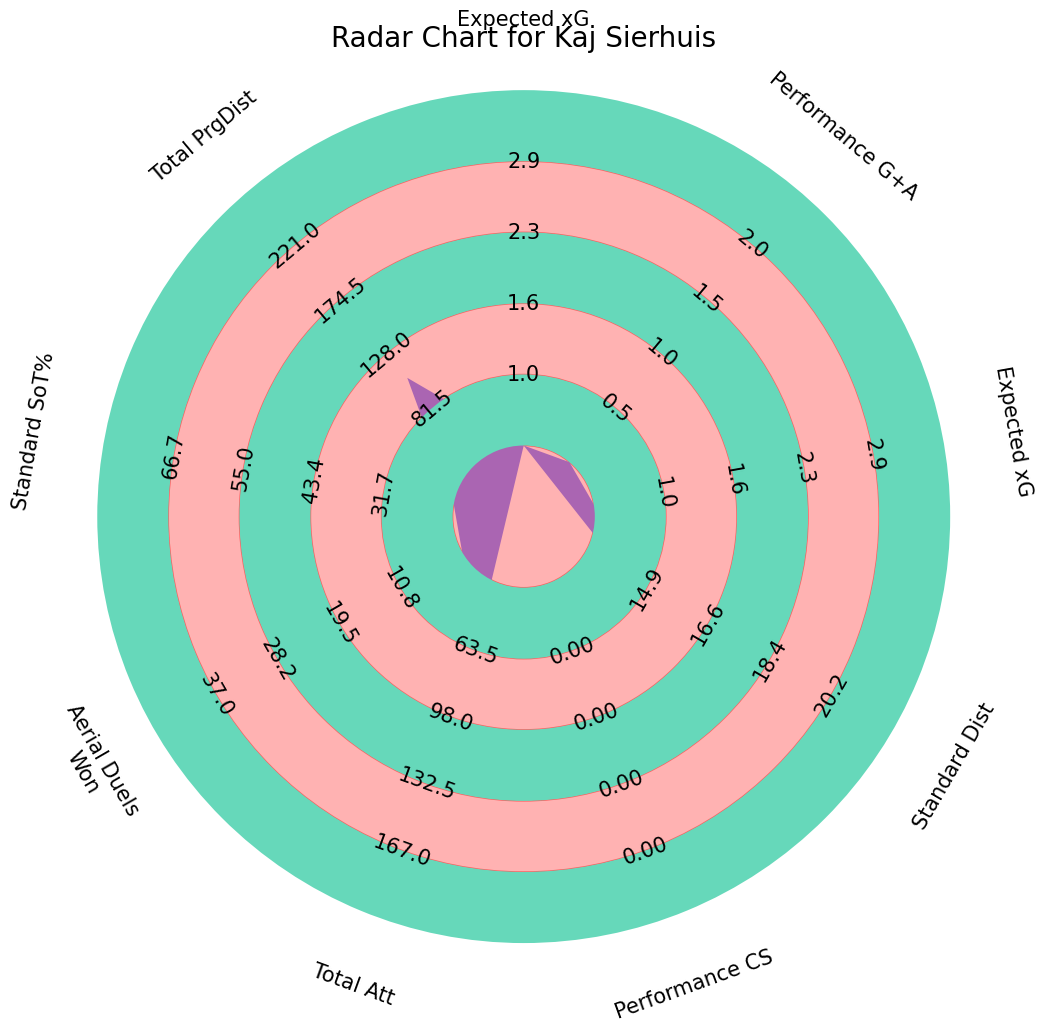

In [13]:
a = find_similar_players(56,df)
a

In [14]:
import pandas as pd

# Sample DataFrame
data = {
    'player': ['Alice', 'Bob', 'Charlie'],
    'score': ['10', '20', '30'],
    'age': ['25', 'invalid', '35'],
    'height': ['5.5', '6.0', 'six']
}

# Creating DataFrame
similar_players_cluster_df = pd.DataFrame(data)

# Columns to be converted to numeric
params = ['score', 'age', 'height']

# Converting specified columns to numeric, setting invalid parsing to NaN
similar_players_cluster_df[params] = similar_players_cluster_df[params].apply(pd.to_numeric, errors='coerce')

print(similar_players_cluster_df)


    player  score   age  height
0    Alice     10  25.0     5.5
1      Bob     20   NaN     6.0
2  Charlie     30  35.0     NaN


In [15]:
 selected_features = ['Pos', 'Age', 'Playing Time MP', 'Performance Gls', 'Performance Ast',
                             'Performance G+A', 'Performance G-PK', 'Performance Fls',
                             'Performance Fld', 'Performance Crs', 'Performance Recov',
                             'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
                             'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
                             'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
                             'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
                             'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
                             'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
                             'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
                             'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
                             'Performance Saves', 'Performance Save%', 'Performance CS',
                             'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
                             'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
                             'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
                             'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

In [19]:
df_player_norm = df.copy()
player_id =123
target_player = df_player_norm[df_player_norm['Rk'] == player_id]
target_features = target_player[selected_features]
target_cluster = target_player['Cluster'].iloc[0]  # Get the cluster label of the target player
target_cluster

2